# Create a Siamese Network with Triplet Loss in Keras

# Import

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


# Functions

In [4]:
def plot_triplet(triplet):
    plt.figure(figsize=(6,2))
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.imshow(np.reshape(triplet[i], (28,28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>


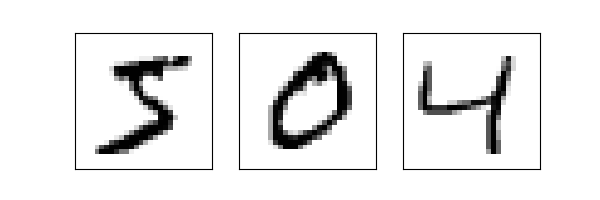

In [5]:
plot_triplet([x_train[0], x_train[1], x_train[2]])

In [6]:
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 784))
    positives = np.zeros((batch_size, 784))
    negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        index = random.randint(0, 60000-1)
        anc = x_train[index]
        y = y_train[index]
        
        indices_pos = np.squeeze(np.where(y_train == y))
        indices_neg = np.squeeze(np.where(y_train != y))
        
        pos = x_train[indices_pos[random.randint(0, len(indices_pos)-1)]]
        neg = x_train[indices_neg[random.randint(0, len(indices_neg)-1)]]
        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

<IPython.core.display.Javascript object>


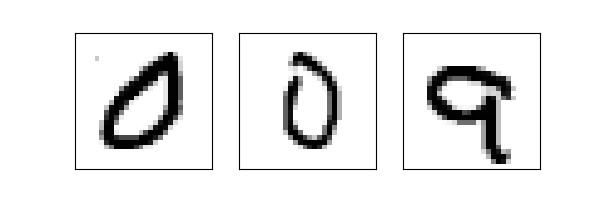

In [15]:
triplet = create_batch(1)
plot_triplet(triplet)

# Embedding Model

In [8]:
emb_dim = 64
embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu',input_shape=(784,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
example = x_train[0]
example_emb = embedding_model.predict(np.expand_dims(example, axis=0))  # 1, 784
print(example_emb)

[[0.45344678 0.44289201 0.4848665  0.54095596 0.2990026  0.5435769
  0.44578117 0.51799417 0.54228604 0.64478517 0.5531751  0.63345015
  0.52900344 0.55268514 0.61734354 0.4622436  0.5121943  0.5446992
  0.5282295  0.2915274  0.45707518 0.28436267 0.6091286  0.26849496
  0.6260388  0.5275235  0.36787307 0.5211004  0.6155528  0.40385562
  0.503078   0.43141082 0.5216712  0.38223112 0.35704488 0.5035683
  0.54920244 0.46212026 0.5553583  0.54065967 0.5434818  0.6340549
  0.39653558 0.47441    0.46774516 0.5028282  0.3761737  0.5675824
  0.4798383  0.4476794  0.47613353 0.45380864 0.5694764  0.5640345
  0.62639874 0.44771874 0.44327652 0.44214508 0.4360721  0.54384756
  0.4393396  0.5386096  0.49544096 0.41941512]]


# Siamese Network

In [10]:
inp_anc = tf.keras.layers.Input(shape=(784,))
inp_pos = tf.keras.layers.Input(shape=(784,))
inp_neg = tf.keras.layers.Input(shape=(784,))

emb_anc = embedding_model(inp_anc)
emb_pos = embedding_model(inp_pos)
emb_neg = embedding_model(inp_neg)

outp = tf.keras.layers.concatenate([emb_anc, emb_pos, emb_neg], axis=1) # column wise that's why

net = tf.keras.models.Model(
    [inp_anc, inp_pos, inp_neg], 
    outp
)

net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

# Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [11]:
alpha = 0.2

def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:emb_dim*2], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        
        return tf.maximum(dp-dn+alpha, 0.)
    return loss

In [12]:
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

# Model Training

In [13]:
batch_size = 1024
epochs = 10
steps_per_epoch = int(60000/batch_size)

net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_dim), optimizer='adam')

X, Y = x_test[:1000], y_test[:1000]

<IPython.core.display.Javascript object>


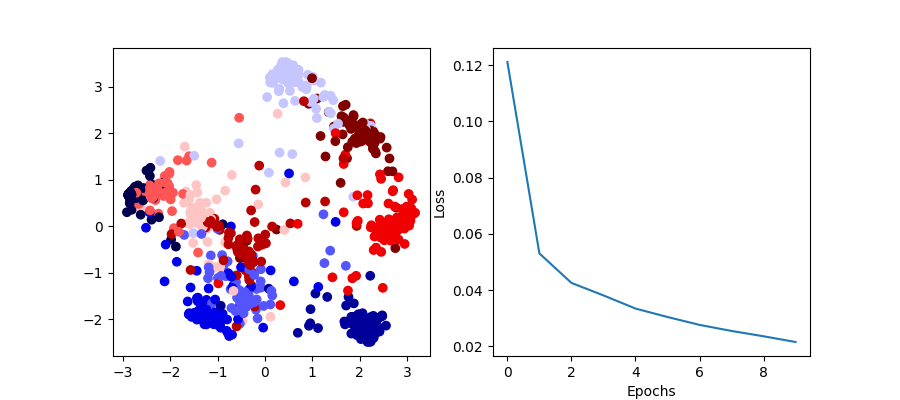

In [14]:
_ = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=False,
    callbacks=[
        PCAPlotter(plt, embedding_model, X, Y)
    ]
)